In [1]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

from guidedbpcodehelpers import imshow2, setbyname
from imgnetdatastuff import dataset_imagenetvalpart,get_classes

## Question 1: L2 Norm of gradient

In [2]:
def get_dataloader():
    root_dir = './mnt/scratch1/data/imagespart/'
    xmllabeldir = './val'
    synsetfile = 'synset_words.txt'
    maxnum = -1
    tfm = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    ds = dataset_imagenetvalpart(
        root_dir, xmllabeldir, synsetfile,
        maxnum, transform=tfm
    )
    return DataLoader(ds, batch_size=1, shuffle=True)

class GradNormHook:
    def __init__(self, model, out_dir):
        self.model = model
        self.model.eval()
        self.out_dir = out_dir
        self.filename = None
        self.register_hooks()
        
    def register_hooks(self):
        def layer1_backward_hook(module, grad_in, grad_out):
            grad = grad_out[0]
            l2_norm = torch.norm(grad, p=2, dim=(2,3))
            np.save(f"{self.out_dir}/{self.filename}_layer1.npy", l2_norm)
        def layer2_backward_hook(module, grad_in, grad_out):
            grad = grad_out[0]
            l2_norm = torch.norm(grad, p=2, dim=(2,3))
            np.save(f"{self.out_dir}/{self.filename}_layer2.npy", l2_norm)
        cnn_modules = self.model.features
        for name, sub_mod in cnn_modules.named_children():
            if name == '0': sub_mod.register_backward_hook(layer1_backward_hook)
            elif name == '2': sub_mod.register_backward_hook(layer2_backward_hook)
    
    def forward(self, sample):
        img, filename = sample['image'], sample['filename']
        self.filename = str(Path(filename[0]).stem)
        # cancel previous gradient
        img = img.requires_grad_(False)
        img = img.requires_grad_()
        self.model.zero_grad()
        pred = self.model(img)
        pred_class = pred.argmax().item()
        target_map = torch.zeros(pred.shape)
        target_map[0][pred_class] = 1
        pred.backward(target_map)

In [3]:
if __name__ == '__main__':
    VGG16_bn = models.vgg16_bn(pretrained=True)
    VGG16 = models.vgg16(pretrained=True)
    gnh_vgg = GradNormHook(VGG16, "VGG16_L2Norm")
    gnh_vgg_bn = GradNormHook(VGG16_bn, "VGG16bn_L2Norm")
    dl = get_dataloader()
    for i, sample in enumerate(dl):
        gnh_vgg.forward(sample)
        gnh_vgg_bn.forward(sample)
        if i == 249: break

## Question 1: 5 ~ 95 Percentile for VGG and VGG_bn's gradient L2 Norm


-------------------- VGG16 --------------------

VGG16 medians:
layer1: [0.26341093 0.30456325 0.41900957 0.08237743 0.33157367 0.05123232
 0.3210876  0.08872193 0.21914777 0.10056125 0.12724648 0.20666659
 0.1606619  0.09395349 0.30206233 0.09183779 0.16580209 0.08792466
 0.22304533 0.4350611  0.24766994 0.25892952 0.1227012  0.2316287
 0.15636735 0.11547442 0.12030238 0.08854114 0.20464604 0.11335806
 0.11214835 0.11258499 0.24923111 0.2690851  0.48737335 0.08261817
 0.10680655 0.07429898 0.16743565 0.24199069 0.17304417 0.06478028
 0.26317564 0.070733   0.13207889 0.08025159 0.10435899 0.20923382
 0.19180888 0.04433039 0.04088576 0.43679133 0.07436992 0.36793113
 0.04944873 0.21583876 0.16818197 0.35882974 0.41446072 0.4512195
 0.11378812 0.10711216 0.05625066 0.17830011]
layer2: [0.07484756 0.04181691 0.18412769 0.08883646 0.155942   0.1539805
 0.07368556 0.11321588 0.12103729 0.07974172 0.15867792 0.12373847
 0.06911548 0.06558575 0.10909028 0.02645868 0.10884087 0.05017291
 0.16

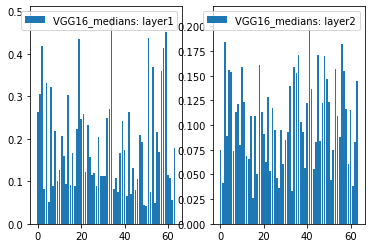

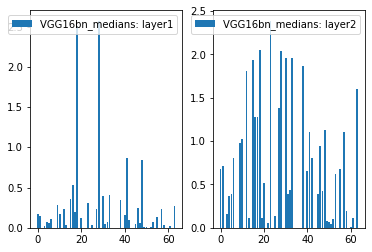

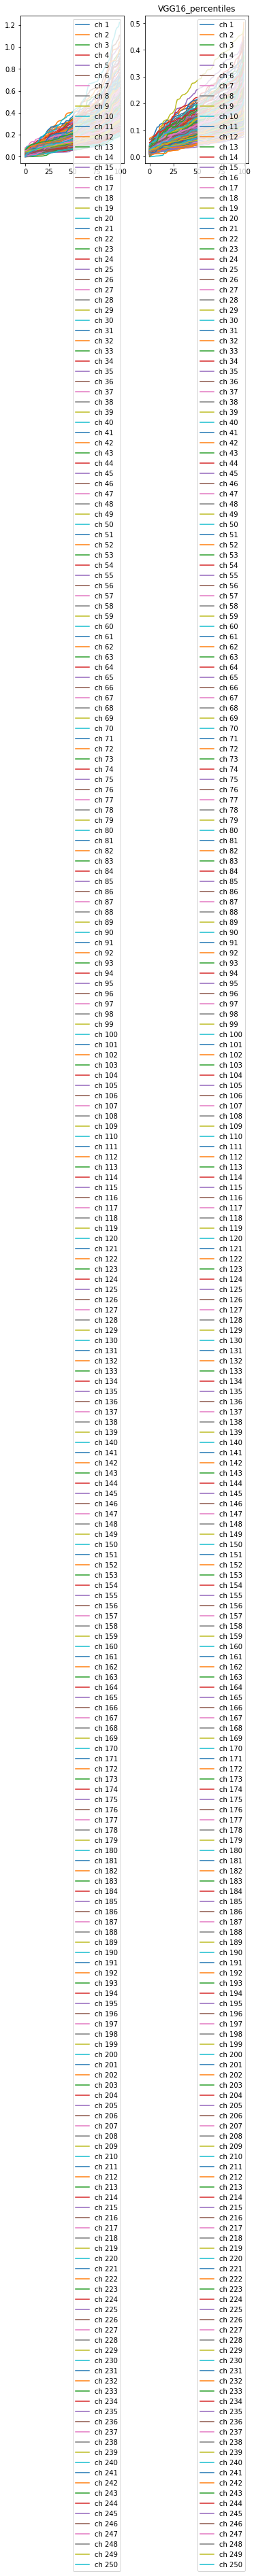

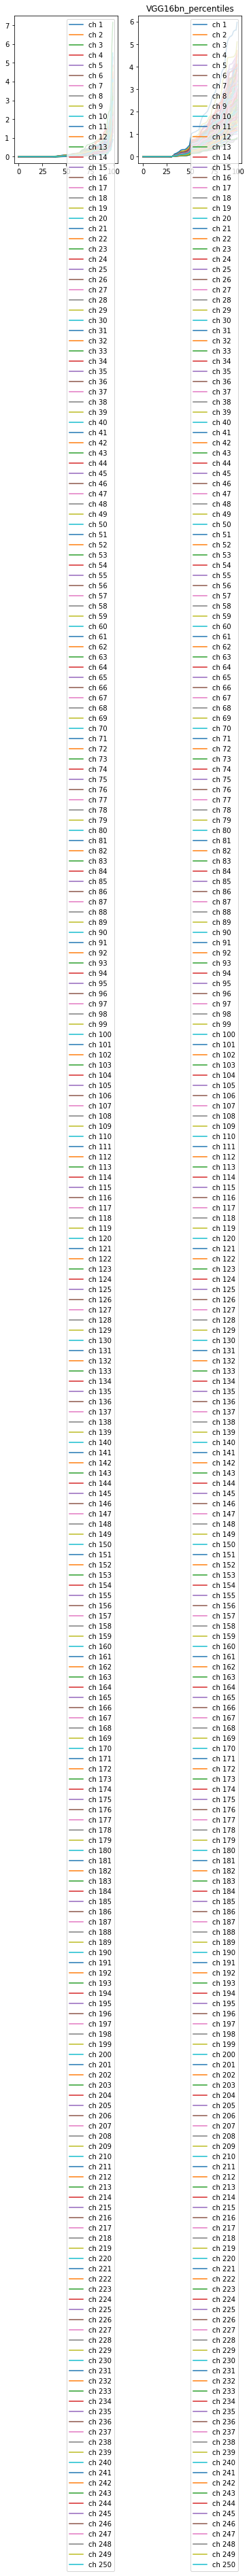

Done


In [4]:
class ResultStatistics():

    def __init__(self, dir):
        self.dir = dir

        self.layer1_norms_stack = None
        self.layer2_norms_stack = None

        self._read_norm_tensors()

    def _read_norm_tensors(self):
        layer1_files = []
        layer2_files = []
        for root, dirs, files in os.walk(self.dir):
            for file in files:
                if file[-5] == "1":
                    layer1_files.append(file)
                elif file[-5] == "2":
                    layer2_files.append(file)

        def read_file_list(file_list, out_tensor=None):
            for i, name in enumerate(file_list):
                file_path = os.path.join(self.dir, name)
                norm_tensor = np.load(file_path)

                if out_tensor is None:
                    out_tensor = norm_tensor
                else:
                    out_tensor = np.concatenate([out_tensor, norm_tensor], axis=0)
            return out_tensor

        self.layer1_norms_stack = read_file_list(layer1_files)
        self.layer2_norms_stack = read_file_list(layer2_files)

    def layer1_percentile(self, p):
        return self._percentile(self.layer1_norms_stack, p)

    def layer2_percentile(self, p):
        return self._percentile(self.layer2_norms_stack, p)

    def _percentile(self, t, p):
        def percentile_1d(t_1d, p):
            result = np.percentile(t_1d, p)
            result = result[np.newaxis, ...]
            return result

        result = []
        for tensor in t.transpose(0, 1):
            channelwise_percentile = percentile_1d(tensor, p)
            result.append(channelwise_percentile)

        result = np.concatenate(result, axis=0)
        return result

    def layer1_median(self):
        return self._median(self.layer1_norms_stack)

    def layer2_median(self):
        return self._median(self.layer2_norms_stack)

    def _median(self, t):
        return np.median(t, axis=0)


if __name__ == '__main__':
    VGG16_statistics = ResultStatistics("VGG16_L2Norm")
    VGG16bn_statistics = ResultStatistics("VGG16bn_L2Norm")

    VGG16_percentiles = {}
    VGG16bn_percentiles = {}

    VGG16_medians = {}
    VGG16bn_medians = {}

    print(f"\n{'-'*20} VGG16 {'-'*20}\n")

    VGG16_medians["layer1"] = VGG16_statistics.layer1_median()
    VGG16_medians["layer2"] = VGG16_statistics.layer2_median()
    print(f"VGG16 medians:")
    print(f"layer1: {VGG16_medians['layer1']}")
    print(f"layer2: {VGG16_medians['layer2']}")

    for p in range(5, 100, 5):
        VGG16_percentiles[p] = {}
        VGG16_percentiles[p]["layer1"] = VGG16_statistics.layer1_percentile(p)
        VGG16_percentiles[p]["layer2"] = VGG16_statistics.layer2_percentile(p)
        print(f"VGG16 {p} percentile:")
        print(f"layer1: {VGG16_percentiles[p]['layer1']}")
        print(f"layer2: {VGG16_percentiles[p]['layer2']}")

    print(f"\n{'-'*20} VGG16bn {'-'*20}\n")

    VGG16bn_medians["layer1"] = VGG16bn_statistics.layer1_median()
    VGG16bn_medians["layer2"] = VGG16bn_statistics.layer2_median()
    print(f"VGG16bn medians:")
    print(f"layer1: {VGG16bn_medians['layer1']}")
    print(f"layer2: {VGG16bn_medians['layer2']}")

    for p in range(5, 100, 5):
        VGG16bn_percentiles[p] = {}
        VGG16bn_percentiles[p]["layer1"] = VGG16bn_statistics.layer1_percentile(p)
        VGG16bn_percentiles[p]["layer2"] = VGG16bn_statistics.layer2_percentile(p)
        print(f"VGG16bn {p} percentile:")
        print(f"layer1: {VGG16bn_percentiles[p]['layer1']}")
        print(f"layer2: {VGG16bn_percentiles[p]['layer2']}")


    def show_medians(medians_dict, medians_name):
        t1 = medians_dict["layer1"]
        t2 = medians_dict["layer2"]

        fig, axs = plt.subplots(1, 2)
        axs[0].bar(range(len(t1)), t1, label=f"{medians_name}: layer1")
        axs[0].legend()
        axs[1].bar(range(len(t2)), t2, label=f"{medians_name}: layer2")
        axs[1].legend()
        plt.savefig(medians_name)
        plt.show()

    def show_percentiles(statistics, figure_name):
        x = list(range(100))
        p1 = [statistics.layer1_percentile(i)[:, np.newaxis, ...] for i in x]
        p1 = np.concatenate(p1, axis=1)

        p2 = [statistics.layer2_percentile(i)[:, np.newaxis, ...] for i in x]
        p2 = np.concatenate(p2, axis=1)

        fig, axs = plt.subplots(1, 2)
        for n, channel in enumerate(p1):
            axs[0].plot(x, channel, label=f"ch {n+1}")
        axs[0].legend()

        for n, channel in enumerate(p2):
            axs[1].plot(x, channel, label=f"ch {n+1}")
        axs[1].legend()

        plt.title(figure_name)
        plt.savefig(figure_name)
        plt.show()


    show_medians(VGG16_medians, "VGG16_medians")
    show_medians(VGG16bn_medians, "VGG16bn_medians")

    show_percentiles(VGG16_statistics, "VGG16_percentiles")
    show_percentiles(VGG16bn_statistics, "VGG16bn_percentiles")

    print("Done")

## Question 2: Guided Backpropagation

components ['features', '1']
components ['1']
components ['features', '3']
components ['3']
components ['features', '6']
components ['6']
components ['features', '8']
components ['8']
components ['features', '11']
components ['11']
components ['features', '13']
components ['13']
components ['features', '15']
components ['15']
components ['features', '18']
components ['18']
components ['features', '20']
components ['20']
components ['features', '22']
components ['22']
components ['features', '25']
components ['25']
components ['features', '27']
components ['27']
components ['features', '29']
components ['29']
components ['classifier', '1']
components ['1']
components ['classifier', '4']
components ['4']
torch.Size([3, 224, 224])


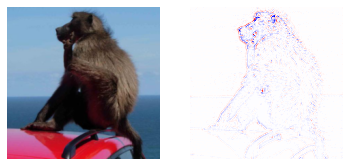

END


In [5]:
class CustomReLU(torch.autograd.Function):

    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < 0] = 0
        grad_input[grad_output < 0] = 0
        return grad_input


class CustomReluModule(nn.Module):

    def __init__(self):
        super(CustomReluModule, self).__init__()

    def forward(self, input):
        return CustomReLU.apply(input)

class Guided_backprop():
    def __init__(self, model):
        self.model = model
        self.image_reconstruction = None
        self.activation_maps = []
        self.model.eval()
        self.replace_modules()

    def replace_modules(self):
        def recursively_replace_modules(module, inherit_name=None):
            for sub_name, sub_module in module.named_children():
                target_name = []
                if inherit_name is not None:
                    target_name.append(inherit_name)
                target_name.append(sub_name)
                target_name = ".".join(target_name)
                if isinstance(sub_module, nn.Sequential):
                    recursively_replace_modules(sub_module, target_name)
                elif isinstance(sub_module, nn.ReLU):
                    success = setbyname(self.model, target_name, CustomReluModule())

        recursively_replace_modules(self.model, None)


    def register_hooks(self):
        def first_layer_hook_fn(module, grad_in, grad_out):
            self.image_reconstruction = grad_in[0]

        def forward_hook_fn(module, input, output):
            self.activation_maps.append(output)

        def backward_hook_fn(module, grad_in, grad_out):
            grad = self.activation_maps.pop()
            grad[grad > 0] = 1
            positive_grad_out = torch.clamp(grad_out[0], min=0.0)
            new_grad_in = positive_grad_out * grad
            return (new_grad_in,)

        for name, module in self.model.features.named_children():
            if isinstance(module, nn.ReLU):
                module.register_forward_hook(forward_hook_fn)
                module.register_backward_hook(backward_hook_fn)

        first_layer = modules[0][1]
        first_layer.register_backward_hook(first_layer_hook_fn)

    def forward(self, input_image, target_class):
        input_image.requires_grad_()
        self.model.zero_grad()
        model_output = self.model(input_image)
        pred_class = model_output.argmax().item()

        grad_target_map = torch.zeros(model_output.shape)

        if target_class is not None:
            grad_target_map[0][target_class] = 1
        else:
            grad_target_map[0][pred_class] = 1

        model_output.backward(grad_target_map)

        result = input_image.grad.data
        return result

if __name__ == '__main__':
    dataloader = get_dataloader()

    model = models.vgg16(pretrained=True)
    guided_bp = Guided_backprop(model)

    img_num = 1
    for i in range(img_num):
        inputs = next(iter(dataloader))

        image = inputs["image"]
        file_name = inputs["filename"]

        result = guided_bp.forward(image, None)

        imshow2(result, image)